In [17]:
import torch
import torch.nn as nn
import gym
import numpy as np


In [18]:
GPU_NUM = 0
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:{}'.format(GPU_NUM) if use_cuda else "cpu")
transition = np.dtype([('s', np.float64, (4, 96, 96)), ('a', np.float64, (3,)), ('a_logp', np.float64),
                       ('r', np.float64), ('s_', np.float64, (4, 96, 96))])
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(device))
print(device)

0
TITAN Xp
cuda:0


In [19]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy,self).__init__()
        self.cnn_layer = nn.Sequential(
                                    nn.Conv2d(4,8,kernel_size=3,stride=1,padding=1),
                                    nn.MaxPool2d(kernel_size=2), #48*48*8
                                    nn.ReLU(),
                                    nn.Conv2d(8,16,kernel_size=3,stride=1,padding=1),
                                    nn.MaxPool2d(kernel_size=2), #24*24*16
                                    nn.ReLU(),
                                    nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),
                                    nn.MaxPool2d(kernel_size=2), #12*12*32
                                    nn.ReLU(),
                                    nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
                                    nn.MaxPool2d(kernel_size=2), #6*6*64
                                    nn.ReLU(),
                                    nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
                                    nn.MaxPool2d(kernel_size=2), #3*3*128
                                    nn.ReLU(),
                                    nn.Conv2d(128,256,kernel_size=3,padding=0), #1*1*256
                                    nn.ReLU()
                                )
        self.fc_v = nn.Sequential(nn.Linear(256,100), nn.ReLU(),nn.Linear(100,1)) # critic -> for getting value function 
        self.fc_1 = nn.Sequential(nn.Linear(256,100),nn.ReLU()) # Actor -> For getting action
        self.fc_alpha = nn.Sequential(nn.Linear(100,3),nn.Softplus())
        self.fc_beta = nn.Sequential(nn.Linear(100,3),nn.Softplus())
        self.apply(self._init_weight)
       
        
    @staticmethod
    def _init_weight(m): # initializing weight
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)
            
    def forward(self,x):
        x = self.cnn_layer(x)
        x = x.view(-1,256)
        v = self.fc_v(x)
        x = self.fc_1(x)
        alpha = self.fc_alpha(x) + 1 # Beta distribution parameter must be greater than 1
        beta = self.fc_beta(x) + 1   # Beta distribution parameter must be greater than 1
        
        return (alpha, beta), v

In [33]:
class Env():
    def __init__(self):
        self.env = gym.make('CarRacing-v0')
        self.env.seed(0)
        self.reward_threshold = self.env.spec.reward_threshold # Car Racing 의 경우 900
    
    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()
        
        self.die = False
        img_rgb = self.env.reset()
        img_gray = self.rgb2gray(img_rgb)
        self.stack = [img_gray] * 4
        
        return np.array(self.stack)
    
    def step(self, action):
        total_reward = 0
        for i in range(4): # action 을 반복해서 하는 이유는 무엇인가??
            img_rgb, reward, die, _ = self.env.step(action)
            # don't penalize "die state"
            if die:
                reward += 100
            # green penalty
            if np.mean(img_rgb[:, :, 1]) > 185.0:
                reward -= 0.05
            total_reward += reward # CarRacing reward = -0.1/frame
            # if no reward recently, end the episode, 100턴동안 안끝나면
            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break
        img_gray = self.rgb2gray(img_rgb)
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == 4
        return np.array(self.stack), total_reward, done, die
        
    def render(self, *arg):
        self.env.render(*arg)
    
    @staticmethod
    def rgb2gray(rgb, norm=True):
        # rgb image -> gray [0, 1]
        gray = np.dot(rgb[..., :], [0.299, 0.587, 0.114])
        if norm:
            # normalize
            gray = gray / 128. - 1.
        return gray
    
    @staticmethod
    def reward_memory():
        # record reward for last 100 steps
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

In [34]:
class Agent():
    buffer_capacity = 2000 # Save 2000 sequence because max is almost 800 in CarRacing-v0
    ppo_epoch = 10
    batch_size = 64
    clip_param = 0.1 # epsilon in PPO
    
    def __init__(self):
        self.net = Policy().double().to(device)
        
    
    def select_action(self,state):
        state = torch.from_numpy(state).double().to(device).unsqueeze(0)
        with torch.no_grad():
            alpha, beta = self.net(state)[0]
        action = (alpha-1)/(alpha+beta-2)
        
        action = action.squeeze().cpu().numpy()
        
        return action
      
    def load_param(self,path):
        self.net.load_state_dict(torch.load(path))

    

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
def show_score(x,y,i_ep):
    display.clear_output(wait=True)
    plt.figure(4)
    plt.plot(x,y)
    plt.show()
    plt.title("CarRacing | episode: {}".format(i_ep))
    plt.axis('off')
    
    

KeyboardInterrupt: 

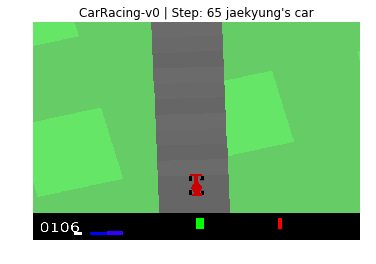

In [36]:
render_env = True

if __name__ == "__main__":
    agent = Agent()
    agent.load_param('/home/jaekyungcho/DRL/CarRacing/model_param/CarRacing_PPO.pkl')
    env = Env()
    
    running_score = 0
    state = env.reset()
    for i_ep in range(10):
        score = 0
        state = env.reset()

        for t in range(20000):
            action = agent.select_action(state)
            state_, reward, done, die = env.step(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))
            if render_env:
                show_state(env.env,t,"jaekyung's car")
            score += reward
            state = state_
            if done or die:
                break

        print('Ep {}\tScore: {:.2f}\t'.format(i_ep, score))